In [1]:
cd .. 

/home/jovyan/2018-W-450-4/03-learning-curves


In [2]:
run __init__.py

In [3]:
run src/load_data.py

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import accuracy_score, f1_score

In [39]:
!conda install tqdm --yes

OSError: [Errno 12] Cannot allocate memory

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
from time import time

In [8]:
adult_train_df = data['adult']['train']['engineered']
adult_train_target = data['adult']['train']['labels']

In [9]:
def sample_training_set(X_train, y_train, n_pcnt):
    n = X_train.shape[0]*n_pcnt//100
    return n, X_train[:n], y_train[:n]

def time_function_call(function_call):
    start = time()
    result = function_call
    execution_time = time() - start
    return result, execution_time

def run_model(model, model_name, n_pcnt, data, labels):

    X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels)

    
    n, X_samp, y_samp = sample_training_set(X_train, y_train, n_pcnt)
    
    _, fit_time = time_function_call(
        model.fit(X_samp, y_samp))
    
    train_pred, train_pred_time = time_function_call(
        model.predict(X_samp))
    
    test_pred, test_pred_time = time_function_call(
        model.predict(X_test))    
    
    return {
            'model' : model,
            'model_name' : model_name,
            'n_pcnt' : n_pcnt,
            'n' : n,
            'f1_train_score' : f1_score(y_samp, train_pred),
            'f1_test_score' : f1_score(y_test, test_pred),
            'accuracy_train_score' : model.score(X_samp, y_samp),
            'accuracy_test_score' : model.score(X_test, y_test),
            'fit_time' : fit_time,
            'train_pred_time' : train_pred_time,
            'test_pred_time' : test_pred_time}

## Variable Ranking - by Single Feature F$_1$ Score 

In [40]:
vr_by_f1_test_scores = []
for feature in tqdm(adult_train_df.columns):
    results = run_model(LogisticRegression(), 'variable ranking', 50, adult_train_df[[feature]], adult_train_target)
    test_score = results['f1_test_score']
    if test_score > 0:
        vr_by_f1_test_scores.append({'feature': feature, 'score' : test_score})


100%|██████████| 103/103 [00:03<00:00, 31.02it/s]


In [41]:
vr_by_f1_results = pd.DataFrame(vr_by_f1_test_scores).sort_values('score', ascending=False)
vr_by_f1_results

,feature,score
1,capital-gain,0.328342
6,education_ Masters,0.214518
2,capital-loss,0.162928
4,workclass_ Self-emp-inc,0.138809
7,education_ Prof-school,0.108776
5,education_ Doctorate,0.064394
3,hours-per-week,0.059988
0,age,0.023428
8,native-country_ France,0.001322


In [12]:
vr_by_f1_performant_features = list(vr_by_f1_results.feature.values)
vr_by_f1_performant_features

['capital-gain',
 'education_ Masters',
 'capital-loss',
 'workclass_ Self-emp-inc',
 'education_ Prof-school',
 'education_ Doctorate',
 'hours-per-week',
 'age']

## Retrain the model

Add one feature at a time.

In [50]:
vr_by_f1_features_to_test = []
vr_by_f1_features_test_results = {}
for i, feature in tqdm(enumerate(vr_by_f1_performant_features)):
    vr_by_f1_features_to_test.append(feature)
    vr_by_f1_features_test_results[feature] = run_model(LogisticRegression(), 'logit', 100,
                                                        adult_train_df[vr_by_f1_features_to_test],
                                                        adult_train_target)

8it [00:00, 12.54it/s]


In [51]:
vr_by_f1_features_test_results = pd.DataFrame(vr_by_f1_features_test_results).T
vr_by_f1_features_test_results

,accuracy_test_score,accuracy_train_score,f1_test_score,f1_train_score,fit_time,model,model_name,n,n_pcnt,test_pred_time,train_pred_time
age,0.810306,0.811732,0.452326,0.454881,3.8147e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,3.8147e-06,4.05312e-06
capital-gain,0.803606,0.798436,0.337103,0.320301,3.57628e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,3.57628e-06,1.54972e-05
capital-loss,0.800574,0.800723,0.34555,0.353408,3.33786e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,3.8147e-06,3.8147e-06
education_ Doctorate,0.811742,0.811785,0.421569,0.427624,3.8147e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,3.8147e-06,3.57628e-06
education_ Masters,0.797543,0.799713,0.31664,0.327019,3.33786e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,3.57628e-06,3.8147e-06
education_ Prof-school,0.79531,0.803117,0.331423,0.370836,3.57628e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,4.05312e-06,4.05312e-06
hours-per-week,0.808711,0.8137,0.449242,0.468195,3.8147e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,3.8147e-06,4.05312e-06
workclass_ Self-emp-inc,0.799298,0.803861,0.346154,0.367627,4.05312e-06,"LogisticRegression(C=1.0, class_weight=None, d...",logit,18803,100,4.05312e-06,3.8147e-06


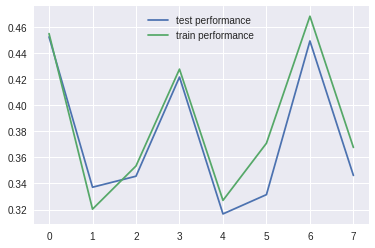

In [52]:
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_train_score, label='train performance')
plt.legend()


## Variable-Ranking - By Regression Coefficient in Full Model

In [53]:
simple_model_results = run_model(LogisticRegression(), 'logit', 100,
                                 adult_train_df,
                                 adult_train_target)

In [54]:
simple_model_results

{'accuracy_test_score': 0.85529674537332478,
 'accuracy_train_score': 0.84927937031324785,
 'f1_test_score': 0.66982162358937025,
 'f1_train_score': 0.65218458517427591,
 'fit_time': 4.291534423828125e-06,
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'model_name': 'logit',
 'n': 18803,
 'n_pcnt': 100,
 'test_pred_time': 4.291534423828125e-06,
 'train_pred_time': 4.291534423828125e-06}

In [18]:
simple_logistic_regression_model = simple_model_results['model']

In [19]:
coefficients = simple_logistic_regression_model.coef_
features = adult_train_df.columns
coefficients = pd.Series(coefficients.T.ravel(), index=features)
coefficients.head()

age                       0.022739
capital-gain              0.000310
capital-loss              0.000591
hours-per-week            0.032260
workclass_ Federal-gov    0.677351
dtype: float64

In [20]:
sorted_coefs = np.abs(coefficients).sort_values(ascending=False)
sorted_coefs.head(20)

sex_ Female                           1.700555
relationship_ Own-child               1.405961
education_ 7th-8th                    1.311505
marital-status_ Never-married         1.242801
education_ Prof-school                1.229797
relationship_ Wife                    1.218684
education_ Doctorate                  1.166777
education_ 11th                       1.048088
occupation_ Farming-fishing           1.028645
education_ 10th                       1.007848
occupation_ Exec-managerial           0.930252
education_ Masters                    0.862183
education_ 9th                        0.808603
relationship_ Other-relative          0.799543
occupation_ Other-service             0.798561
occupation_ Handlers-cleaners         0.762221
marital-status_ Married-civ-spouse    0.761445
occupation_ Prof-specialty            0.722723
sex_ Male                             0.721799
native-country_ Mexico                0.713165
dtype: float64

In [21]:
vr_by_coef_performant_features = list(sorted_coefs.head(20).index)
vr_by_coef_performant_features

['sex_ Female',
 'relationship_ Own-child',
 'education_ 7th-8th',
 'marital-status_ Never-married',
 'education_ Prof-school',
 'relationship_ Wife',
 'education_ Doctorate',
 'education_ 11th',
 'occupation_ Farming-fishing',
 'education_ 10th',
 'occupation_ Exec-managerial',
 'education_ Masters',
 'education_ 9th',
 'relationship_ Other-relative',
 'occupation_ Other-service',
 'occupation_ Handlers-cleaners',
 'marital-status_ Married-civ-spouse',
 'occupation_ Prof-specialty',
 'sex_ Male',
 'native-country_ Mexico']

In [44]:
vr_by_coef_features_to_test = []
vr_by_coef_test_results = {}
for i, feature in tqdm(enumerate(vr_by_coef_performant_features)):
    vr_by_coef_features_to_test.append(feature)
    vr_by_coef_test_results[feature] = run_model(LogisticRegression(), 'logit', 100,
                                                 adult_train_df[vr_by_coef_features_to_test],
                                                 adult_train_target)

20it [00:01, 17.33it/s]


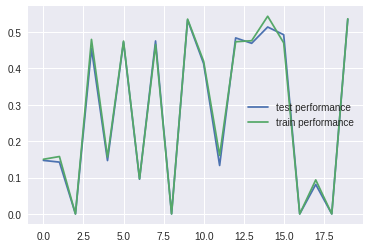

In [45]:
vr_by_coef_test_results = pd.DataFrame(vr_by_coef_test_results).T

plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_train_score, label='train performance')
plt.legend()

In [55]:
vr_by_coef_with_num_features_to_test = ['age', 'capital-gain','capital-loss','hours-per-week']
vr_by_coef_with_num_test_results = {}
for i, feature in tqdm(enumerate(vr_by_coef_performant_features)):
    vr_by_coef_with_num_features_to_test.append(feature)
    vr_by_coef_with_num_test_results[feature] = run_model(LogisticRegression(), 'logit', 100,
                                                          adult_train_df[vr_by_coef_with_num_features_to_test],
                                                          adult_train_target)

20it [00:02,  6.97it/s]


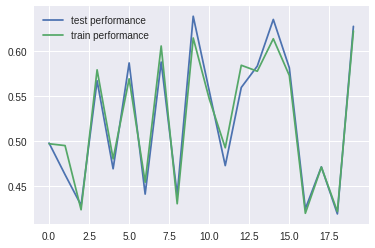

In [56]:
vr_by_coef_with_num_test_results = pd.DataFrame(vr_by_coef_with_num_test_results).T

plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_train_score, label='train performance')
plt.legend()

## Variable-Ranking - By Information Gain in Full Model

In [26]:
simple_dtree_results = run_model(DecisionTreeClassifier(), 'dtree', 100,
                                 adult_train_df,
                                 adult_train_target)

In [27]:
simple_dtree_results

{'accuracy_test_score': 0.8284939374601149,
 'accuracy_train_score': 0.98181141307238207,
 'f1_test_score': 0.63422932970398094,
 'f1_train_score': 0.96128594068372197,
 'fit_time': 5.245208740234375e-06,
 'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 'model_name': 'dtree',
 'n': 18803,
 'n_pcnt': 100,
 'test_pred_time': 3.337860107421875e-06,
 'train_pred_time': 4.0531158447265625e-06}

In [28]:
simple_decision_tree_model = simple_dtree_results['model']

In [29]:
feature_importances = simple_decision_tree_model.feature_importances_
features = adult_train_df.columns
feature_importances = pd.Series(feature_importances.T.ravel(), index=features)
feature_importances.head()

age                       0.174207
capital-gain              0.129836
capital-loss              0.041658
hours-per-week            0.097734
workclass_ Federal-gov    0.006372
dtype: float64

In [30]:
sorted_importances = feature_importances.sort_values(ascending=False)
sorted_coefs = np.abs(coefficients).sort_values(ascending=False)
sorted_importances = pd.DataFrame(sorted_importances, columns=['importances'])
sorted_importances['importance_feature'] = sorted_importances.index
sorted_importances.reset_index(drop=True, inplace=True)
sorted_coefs = pd.DataFrame(sorted_coefs, columns=['regression coefs'])
sorted_coefs['reg_coef_feature'] = sorted_coefs.index
sorted_coefs.reset_index(drop=True, inplace=True)
sorted_feats = pd.merge(sorted_importances, sorted_coefs, left_index=True, right_index=True)
sorted_feats.head(10)

,importances,importance_feature,regression coefs,reg_coef_feature
0,0.204611,marital-status_ Married-civ-spouse,1.700555,sex_ Female
1,0.174207,age,1.405961,relationship_ Own-child
2,0.129836,capital-gain,1.311505,education_ 7th-8th
3,0.097734,hours-per-week,1.242801,marital-status_ Never-married
4,0.041658,capital-loss,1.229797,education_ Prof-school
5,0.029947,education_ Bachelors,1.218684,relationship_ Wife
6,0.026326,education_ Masters,1.166777,education_ Doctorate
7,0.021221,occupation_ Prof-specialty,1.048088,education_ 11th
8,0.015985,workclass_ Private,1.028645,occupation_ Farming-fishing
9,0.014516,occupation_ Exec-managerial,1.007848,education_ 10th


In [31]:
importance_performant_features = list(sorted_feats.importance_feature.head(20))
importance_performant_features

['marital-status_ Married-civ-spouse',
 'age',
 'capital-gain',
 'hours-per-week',
 'capital-loss',
 'education_ Bachelors',
 'education_ Masters',
 'occupation_ Prof-specialty',
 'workclass_ Private',
 'occupation_ Exec-managerial',
 'workclass_ Self-emp-not-inc',
 'education_ Some-college',
 'education_ HS-grad',
 'occupation_ Sales',
 'occupation_ Craft-repair',
 'race_ White',
 'native-country_ United-States',
 'race_ Black',
 'occupation_ Adm-clerical',
 'workclass_ Local-gov']

In [32]:
vr_importance_features_to_test = []
vr_importance_test_results = {}
for feature in tqdm(importance_performant_features):
    vr_importance_features_to_test.append(feature)
    vr_importance_test_results[feature+'_dtree'] = run_model(DecisionTreeClassifier(), 'dtree', 50,
                                                             adult_train_df[vr_importance_features_to_test],
                                                             adult_train_target)
    vr_importance_test_results[feature+'_logit'] = run_model(LogisticRegression(), 'logit', 50,
                                                             adult_train_df[vr_importance_features_to_test],
                                                             adult_train_target)

100%|██████████| 20/20 [02:15<00:00,  6.78s/it]


In [33]:
vr_importance_test_results = pd.DataFrame(vr_importance_test_results).T

In [34]:
dtree_results = vr_importance_test_results[vr_importance_test_results.model_name == 'dtree']
logit_results = vr_importance_test_results[vr_importance_test_results.model_name == 'logit']

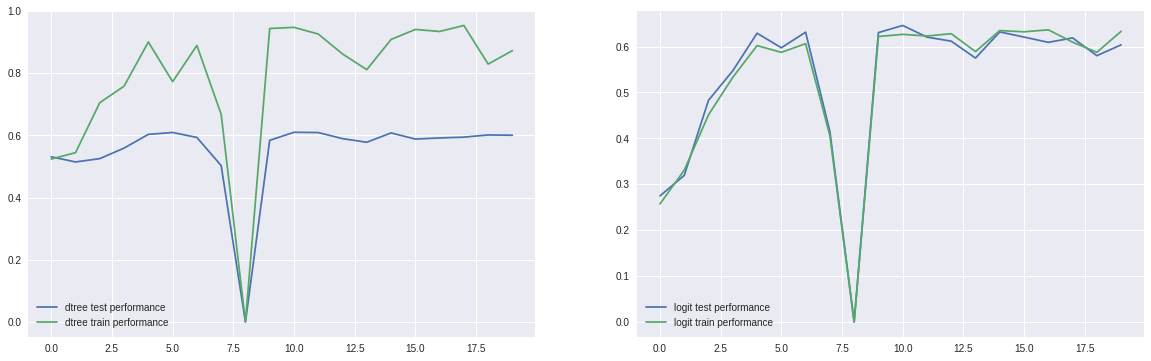

In [35]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_train_score, label='dtree train performance')
plt.legend()
fig.add_subplot(1,2,2)
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_test_score, label='logit test performance')
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_train_score, label='logit train performance')
plt.legend()

In [36]:
whos list

Variable                               Type    Data/Info
--------------------------------------------------------
importance_performant_features         list    n=20
numeric_features                       list    n=4
vr_by_coef_features_to_test            list    n=20
vr_by_coef_performant_features         list    n=20
vr_by_coef_with_num_features_to_test   list    n=24
vr_by_f1_features_to_test              list    n=8
vr_by_f1_performant_features           list    n=8
vr_by_f1_test_scores                   list    n=8
vr_importance_features_to_test         list    n=20


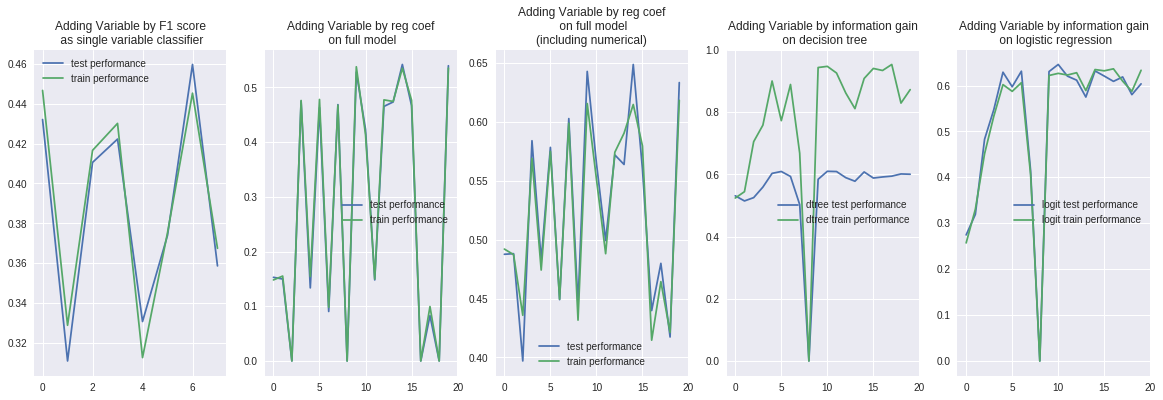

In [37]:

fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,5,1)
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_f1_features_to_test)), vr_by_f1_features_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by F1 score\n as single variable classifier')
plt.legend()
fig.add_subplot(1,5,2)
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_features_to_test)), vr_by_coef_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by reg coef\n on full model')
plt.legend()
fig.add_subplot(1,5,3)
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_test_score, label='test performance')
plt.plot(range(len(vr_by_coef_with_num_features_to_test)-4), vr_by_coef_with_num_test_results.f1_train_score, label='train performance')
plt.title('Adding Variable by reg coef\n on full model\n(including numerical)')
plt.legend()
fig.add_subplot(1,5,4)
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_train_score, label='dtree train performance')
plt.title('Adding Variable by information gain\n on decision tree')
plt.legend()
fig.add_subplot(1,5,5)
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_test_score, label='logit test performance')
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_train_score, label='logit train performance')
plt.title('Adding Variable by information gain\n on logistic regression')
plt.legend()

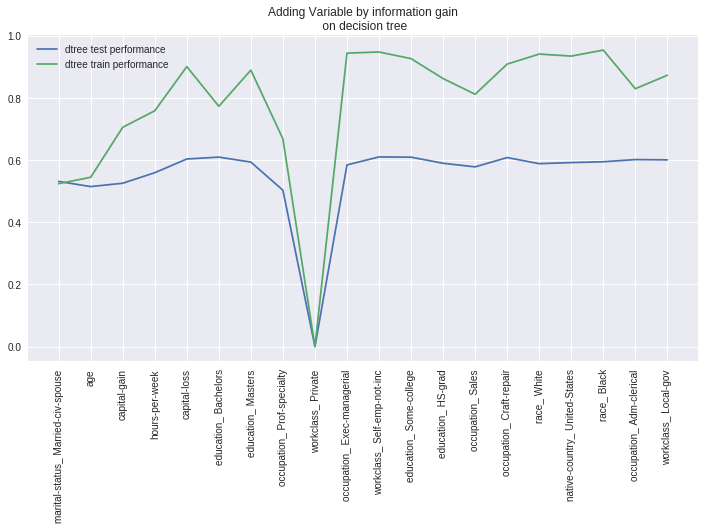

In [38]:
plt.figure(figsize=(12,6))
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), dtree_results.f1_train_score, label='dtree train performance')
plt.title('Adding Variable by information gain\n on decision tree')
plt.xticks(range(len(vr_importance_features_to_test)), vr_importance_features_to_test, rotation='vertical')
plt.legend()



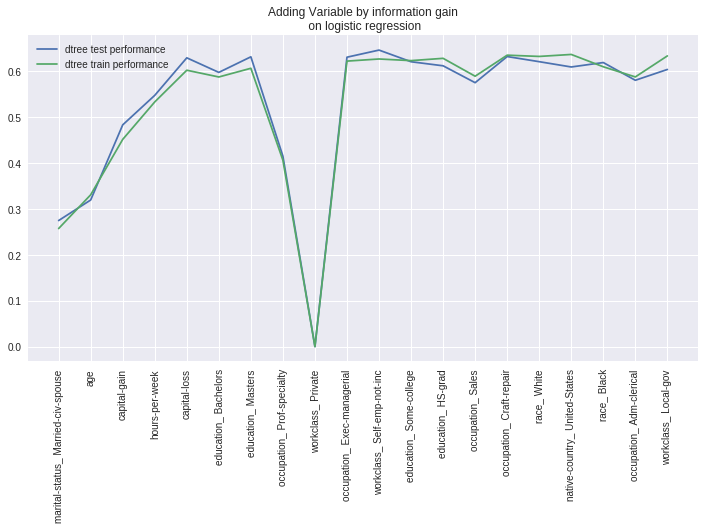

In [57]:
plt.figure(figsize=(12,6))
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_test_score, label='dtree test performance')
plt.plot(range(len(vr_importance_features_to_test)), logit_results.f1_train_score, label='dtree train performance')
plt.title('Adding Variable by information gain\n on logistic regression')
plt.xticks(range(len(vr_importance_features_to_test)), vr_importance_features_to_test, rotation='vertical')
plt.legend()


